In [35]:
## Helper functions for downloading photon ranch files ##

import json
import requests
from astropy.io import fits
import numpy as np

def get_image_urls(base_filename):
    """
    Get urls for jpg and fits files taken at photon ranch. 
    
    The base filename is the filename starting with the sitecode and ending before
    the EX00 number. 
    
    Example: 'saf-sq01-20200628-00000408' 
    
    """
    # Photon ranch api to get the image urls
    url = "https://api.photonranch.org/api/download"
    
    # Fits
    body = json.dumps({"object_name": f"{base_filename}-EX10.fits.bz2"})
    fits_url = requests.post(url, body).text
    
    # Jpg
    body = json.dumps({"object_name": f"{base_filename}-EX10.jpg"})
    jpg_url = requests.post(url, body).text
    
    # Check if url is valid:
    status_code = requests.get(fits_url).status_code
    
    return {
        "ok": status_code == 200,
        "jpg": jpg_url,
        "fits": fits_url,
    }

def np_array_from_fits_url(url):
    data = fits.open(url)[0].data
    return data

def trim_top_bottom_edges(input_data):
    # Deep copy so the input data array doesn't change.
    data = np.empty_like(input_data)
    data[:] = input_data
    shape = data.shape
    num_rows = shape[0]
    row_indices_to_discard = np.empty((0))
    # remove the top and bottom fifth
    for i in range(int(num_rows / 5)):
        # top rows
        row_indices_to_discard = np.append(row_indices_to_discard, i)
        # bottom rows
        row_indices_to_discard = np.append(row_indices_to_discard, num_rows-i-1)
    row_indices_to_discard = row_indices_to_discard.astype(int)
    data = np.delete(data, row_indices_to_discard, axis=0)
    return data


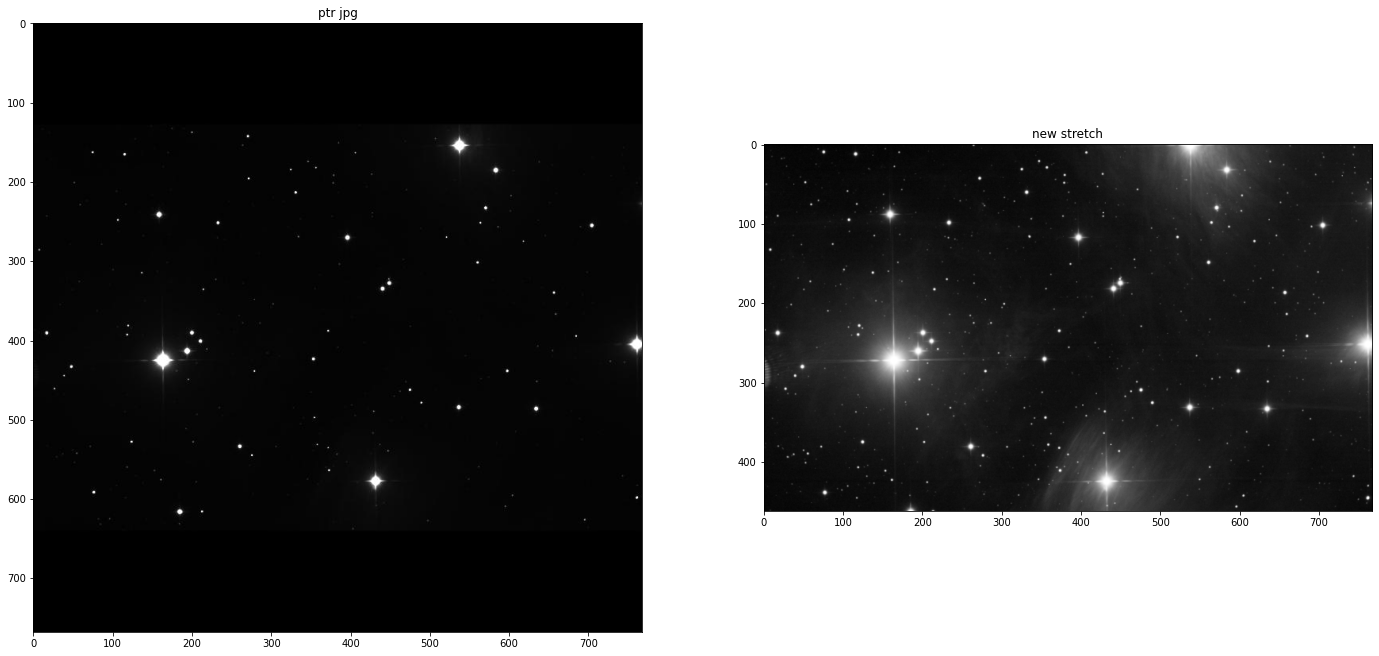

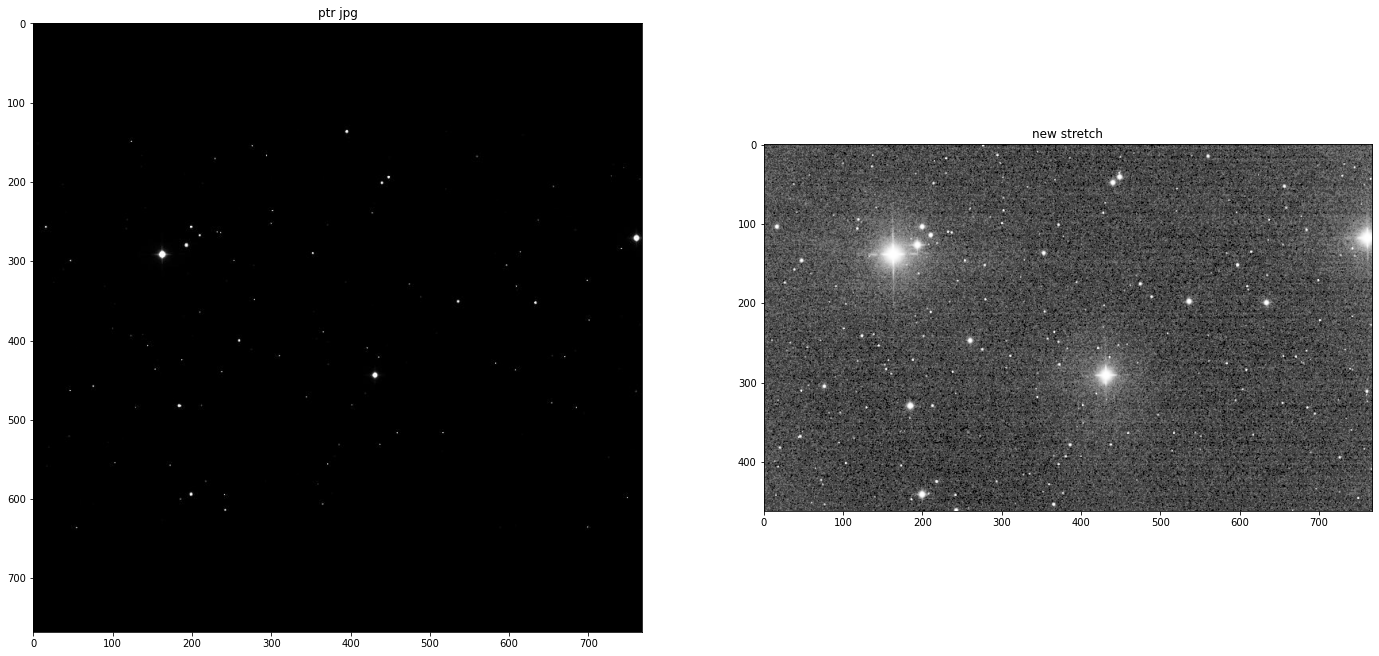

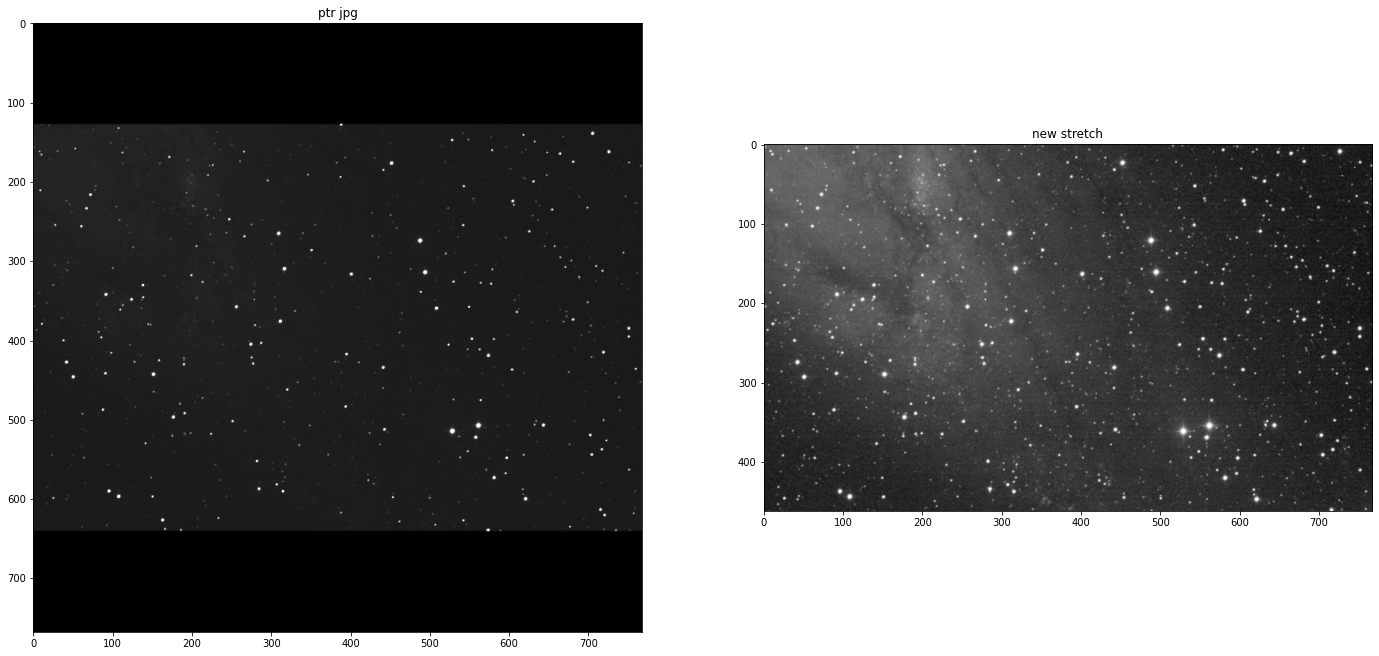

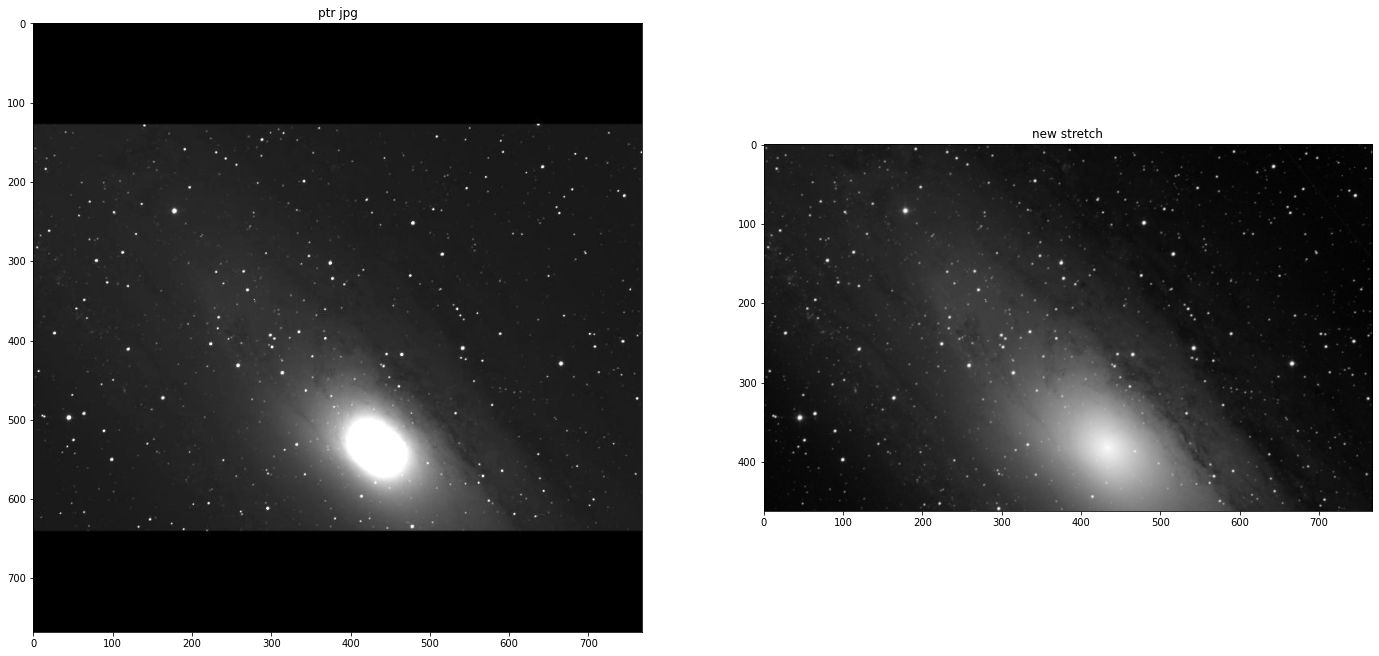

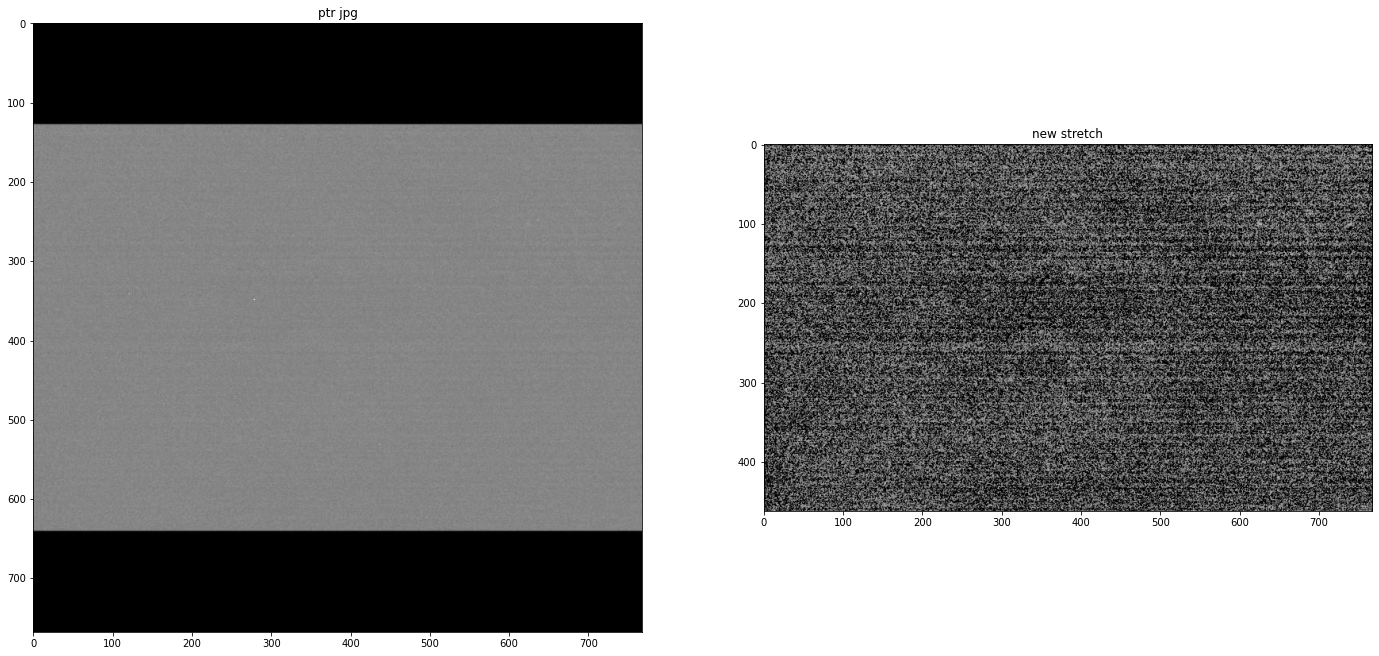

In [37]:
# This does the stretching.
from auto_stretch.stretch import Stretch

# for downloading and viewing the ptr jpg
import urllib
from PIL import Image
from io import BytesIO

# for plotting the images
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Plotting config
matplotlib.rcParams['figure.figsize'] = [24,24]





# Some ptr files to demonstrate:
base_filenames = [
    'saf-sq01-20201012-00003780',  # M45
    'saf-sq01-20201012-00003777',  # M45 in O3
    'saf-sq01-20201012-00003666',  # M31
    'saf-sq01-20201012-00003671',  # M31
    'saf-sq01-20201013-00003885',  # Calibration frame
]

for file in base_filenames:
    
    # get np array
    urls = get_image_urls(file)
    data_array = np_array_from_fits_url(urls["fits"])
    data_array = trim_top_bottom_edges(data_array)
    
    # stretch
    stretched_image = Stretch().stretch(data_array)
    
    # plot stretched image
    f, axarr = plt.subplots(1,2)
    axarr[1].imshow(stretched_image, cmap='gray')
    axarr[1].title.set_text('new stretch')
    
    # plot old comparison
    img_bytes = urllib.request.urlopen(urls["jpg"]).read()
    img = Image.open(BytesIO(img_bytes))
    axarr[0].imshow(img, cmap='gray')
    axarr[0].title.set_text('ptr jpg')
    
    